In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_ap_ars

from models.setup import ModelSetup
from models.build import create_multimodal_rcnn_model
from models.train import TrainingInfo
from utils.save import check_best, end_train, get_data_from_metric_logger
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss, get_params
from utils.init import reproducibility, clean_memory_get_device
from data.constants import DEFAULT_REFLACX_LABEL_COLS
from data.paths import XAMI_MIMIC_PATH
from datetime import datetime



## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])

common_args = {
    "save_early_stop_model": True,
    "optimiser": "sgd",
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "image_backbone_pretrained": True,
    "heatmap_backbone_pretrained": True,
    "record_training_performance": True,
    "batch_size": 4,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",
    "reduceLROnPlateau_factor": 0.1,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": True,
    "multiStepLR_milestones": 100,
    "multiStepLR_gamma": 0.1,
    "use_mask": True,
    "gt_in_train_till": 10,
    # "gt_in_train_till": 999,
    "box_head_dropout_rate": 0,
    "measure_test": True,
}

small_image_args = {
    "image_size": 256,
}

big_image_args = {
    "image_size": 512,
}

fusion_add_args = {
    "fuse_depth": 0,
    "fusion_residule": False,
    "fusion_strategy": "add", 
}

fusion_multiply_args = {
    "fuse_depth": 0,
    "fusion_residule": False,
    "fusion_strategy": "multiply", 
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "representation_size": 64, 
    "backbone_out_channels": 64,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}


# does this one use FPN?
resnet_args = {
    "backbone": "resnet18",
    "using_fpn": False,
}

In [4]:
all_model_setups = [
    ModelSetup(
        name="label_testing",
        use_heatmaps=False,
        with_pupil=False,
        **big_image_args,
        # **resnet_args,
        **mobilenet_args,
        **small_model_args,
        **common_args,
        **fusion_add_args,
    ), 
    # ModelSetup(
    #     name="label_testing",
    #     use_heatmaps=False,
    #     with_pupil=False,
    #     **big_image_args,
    #     **resnet_args,
    #     # **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    # ),
    # ModelSetup(
    #     name="label_testing",
    #     use_heatmaps=False,
    #     with_pupil=False,
    #     **small_image_args,
    #     # **resnet_args
    #     **mobilenet_args,
    #     **small_model_args,
    #     **common_args,
    #     **fusion_add_args,
    # ),
]

In [5]:
num_epochs = 200
train_infos = []

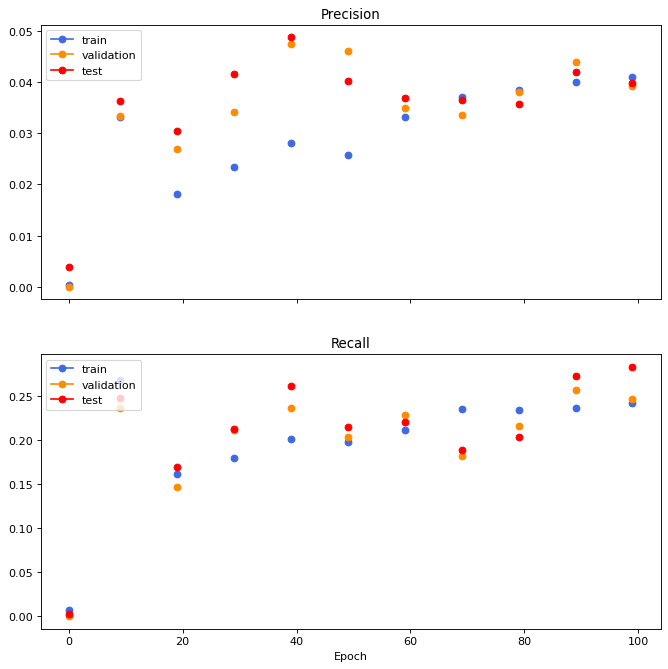

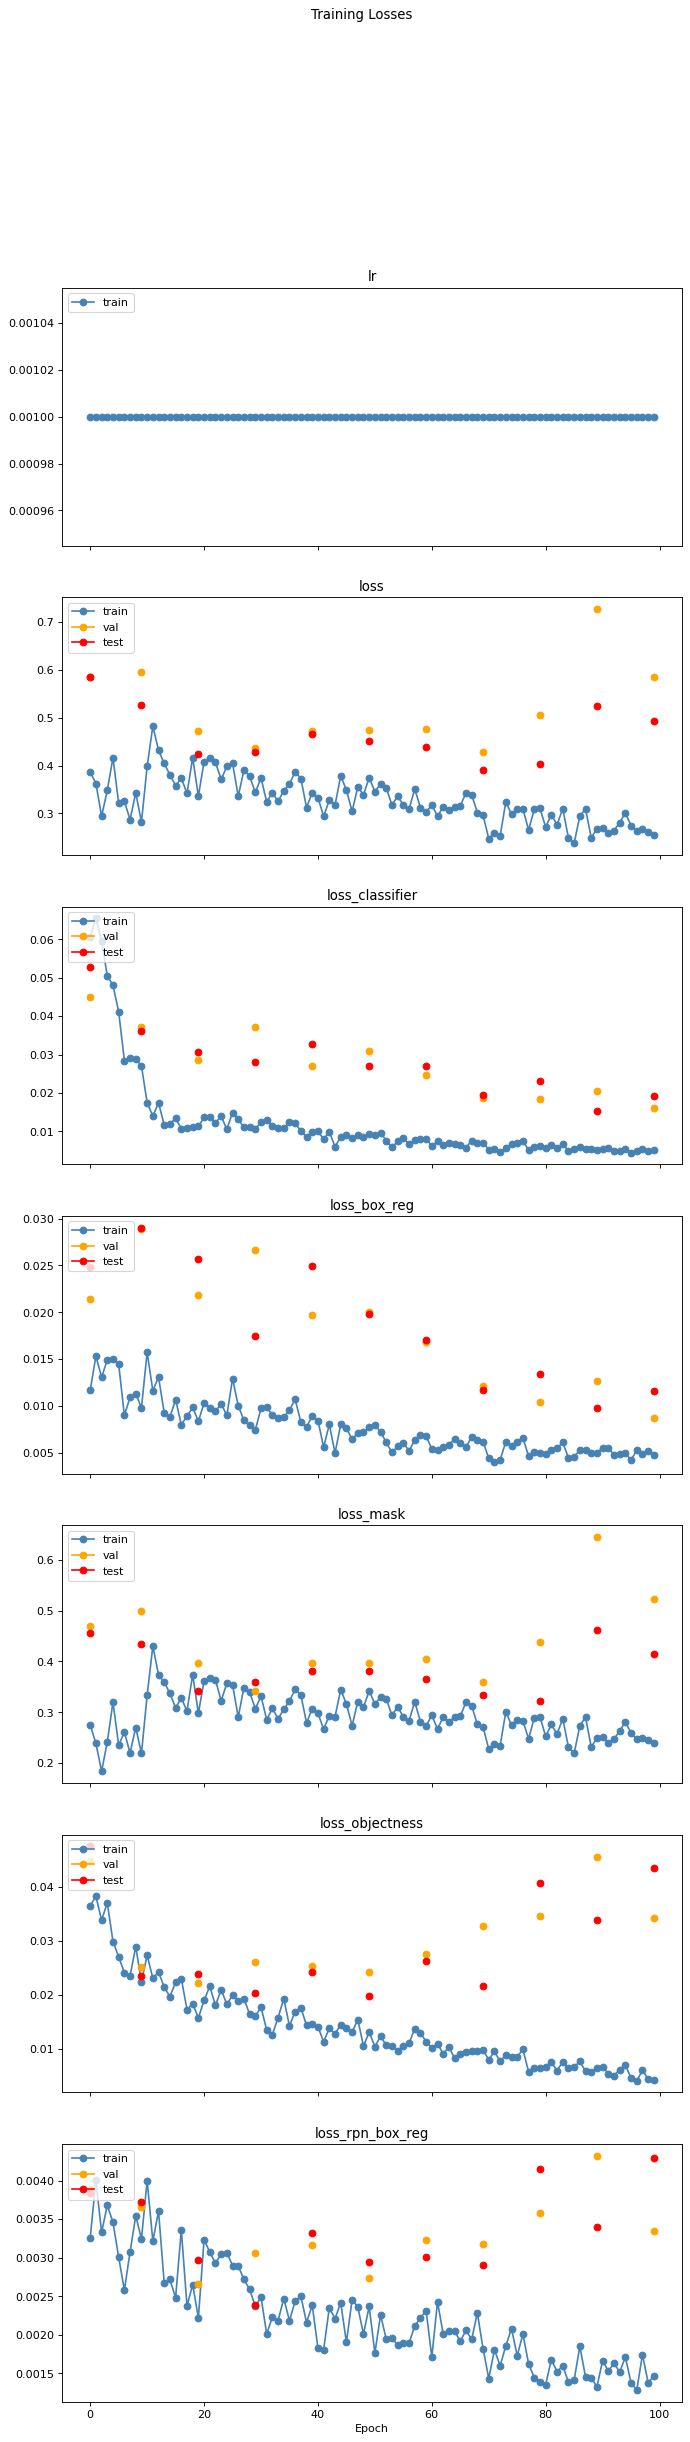

====================| Epoch [100] Done | It has took [1224.13] min, Avg time: [734.48] sec/epoch | Estimate time for [100] epochs: [1224.13] min | Epoch took [962] sec | Patience [0] |====================
====================| Training Done, start testing! | [100] Epochs Training time: [73448] seconds, Avg time / Epoch: [734.48] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_2357_ap_0_0475_test_ar_0_2608_ap_0_0488_epoch40_11-21-2022 20-46-57_label_testing]====================
====================Best AR validation model has been saved to: [val_ar_0_2562_ap_0_0439_test_ar_0_2728_ap_0_0419_epoch90_11-22-2022 06-57-45_label_testing]====================
Evaluation:  [  0/114]  eta: 0:01:53  loss: 0.0890 (0.0890)  loss_classifier: 0.0053 (0.0053)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.0781 (0.0781)  loss_rpn_box_reg: 0.0057 (0.0057)  model_time: 0.1757 (0.1757)  evaluator_time: 0.2261 (0.2261)  ti

In [6]:
## we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.

for model_setup in all_model_setups:

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(model_setup)

    if model_setup.measure_test:
        # initialise the test recording list.
        train_info.test_ap_ars = []

    model = create_multimodal_rcnn_model(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.to(device)
    print_params_setup(model)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_fixations": model_setup.with_fixations,
        "with_pupil": model_setup.with_pupil,
        "with_1st_third_fixations": model_setup.with_1st_third_fixations,
        "with_2nd_third_fixations": model_setup.with_2nd_third_fixations,
        "with_rad_silence": model_setup.with_rad_silence,
        "with_rad_speaking": model_setup.with_rad_speaking,
        "bbox_to_mask": model_setup.use_mask,
        "labels_cols": labels_cols,
    }

    print("Dataloader creating...")

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
    )

    print("Dataloader created!!")
    print("CoCo and eval_params creating...")

    train_coco = None
    train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
        train_dataloader,
        val_dataloader,
        test_dataloader,
        detect_eval_dataset,
        iou_thrs,
        use_iobb,
    )

    print("CoCo and eval_params Created")

    print("Initialising Loss and Optimiser...")

    dynamic_loss_weight = None
    dynamic_loss_weight = get_dynamic_loss(model_setup, device)
    params = get_params(model, dynamic_loss_weight)
    iou_types = get_iou_types(model, model_setup)
    optimizer = get_optimiser(params, model_setup)
    lr_scheduler = get_lr_scheduler(optimizer, model_setup)

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Took [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_loss = None

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        if train_info.epoch > model_setup.gt_in_train_till:
            model.roi_heads.use_gt_in_train = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        train_data_keys = train_info.train_losses[0].keys()
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######

        if train_info.epoch == 1 or train_info.epoch % model_setup.eval_freq == 0:
            model.eval()
            train_info.last_val_evaluator, val_logger = xami_evaluate(
                model=model,
                data_loader=val_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=val_coco,
                iou_types=iou_types,
                score_thres=None,
            )

            # train_info.val_evaluators.append(val_evaluator)
            train_info.val_losses.append(get_data_from_metric_logger(val_logger))

            train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
                train_info.last_train_evaluator,
                train_info.last_val_evaluator,
                areaRng="all",
                iouThr=0.5,
                maxDets=10,
            )

            train_info.train_ap_ars.append(train_ap_ar)
            train_info.val_ap_ars.append(val_ap_ar)

            if model_setup.measure_test:
                train_info.test_evaluator, test_logger = xami_evaluate(
                    model=model,
                    data_loader=test_dataloader,
                    device=device,
                    params_dict=eval_params_dict,
                    coco=test_coco,
                    iou_types=iou_types,
                    score_thres=None,
                )
                train_info.test_losses.append(get_data_from_metric_logger(test_logger))
                test_ap_ar = get_ap_ar(
                    train_info.test_evaluator, areaRng="all", iouThr=0.5, maxDets=10,
                )
                train_info.test_ap_ars.append(test_ap_ar)

            ### update the learning rate

            # val_loss = train_info.val_losses[-1]["loss"]

        else:
            # null loss.
            train_info.val_losses.append({k: np.nan for k in train_data_keys})
            train_info.test_losses.append({k: np.nan for k in train_data_keys})

            # null evaluation performance
            train_info.train_ap_ars.append({"ap": np.nan, "ar": np.nan})
            train_info.val_ap_ars.append({"ap": np.nan, "ar": np.nan})

            if model_setup.measure_test:
                train_info.test_ap_ars.append({"ap": np.nan, "ar": np.nan})

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        if model_setup.record_training_performance:
            plot_ap_ars(
                train_ap_ars=train_info.train_ap_ars,
                val_ap_ars=train_info.val_ap_ars,
                test_ap_ars=train_info.test_ap_ars,
            )

        plot_losses(
            train_info.train_losses,
            train_info.val_losses,
            test_logers=train_info.test_losses,
        )

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        # print('below plots')

        #######################################################################################
        if model_setup.save_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                val_ap_ar=val_ap_ar,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
                dynamic_weight=dynamic_loss_weight,
            )

        # print('end of loop')

    val_ap_ar = get_ap_ar(train_info.last_val_evaluator)

    # print('check')

    train_info = end_train(
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ap_ar["ar"],
        last_val_ap=val_ap_ar["ap"],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
        dynamic_weight=dynamic_loss_weight,
    )

    train_infos.append(train_info)


# what's the performance we can get with more or less labels?
# what's the performance we can get with different values of gt_in_train_till.

# [584.51] sec/epoch (512)
#

# let's see if the model can use the same argument (baseline) to fit on the same dataset (reflacx_clinical).


========================================For Training [label_testing]========================================
ModelSetup(name='label_testing', use_heatmaps=False, with_fixations=False, with_pupil=False, with_1st_third_fixations=False, with_2nd_third_fixations=False, with_rad_silence=False, with_rad_speaking=False, save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, heatmap_backbone_pretrained=True, image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, fusion_strategy='add', fusion_residule=False, gt_in_train_till=10, measure_test=True, eval

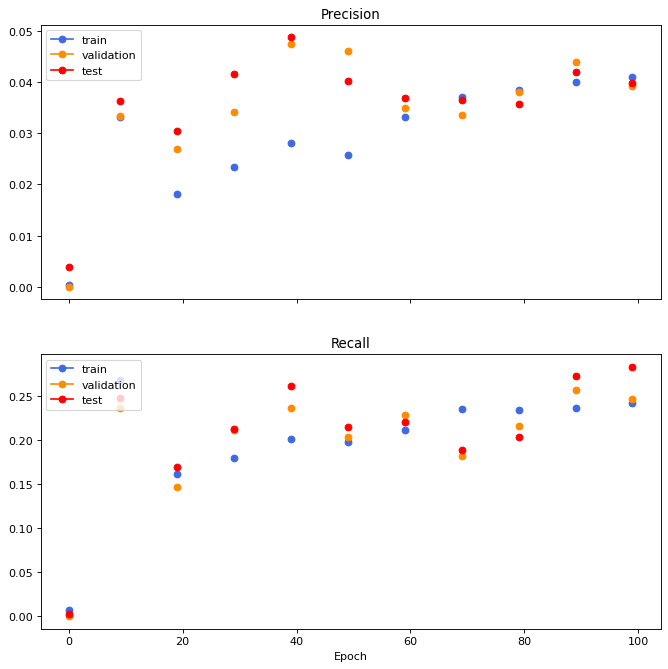

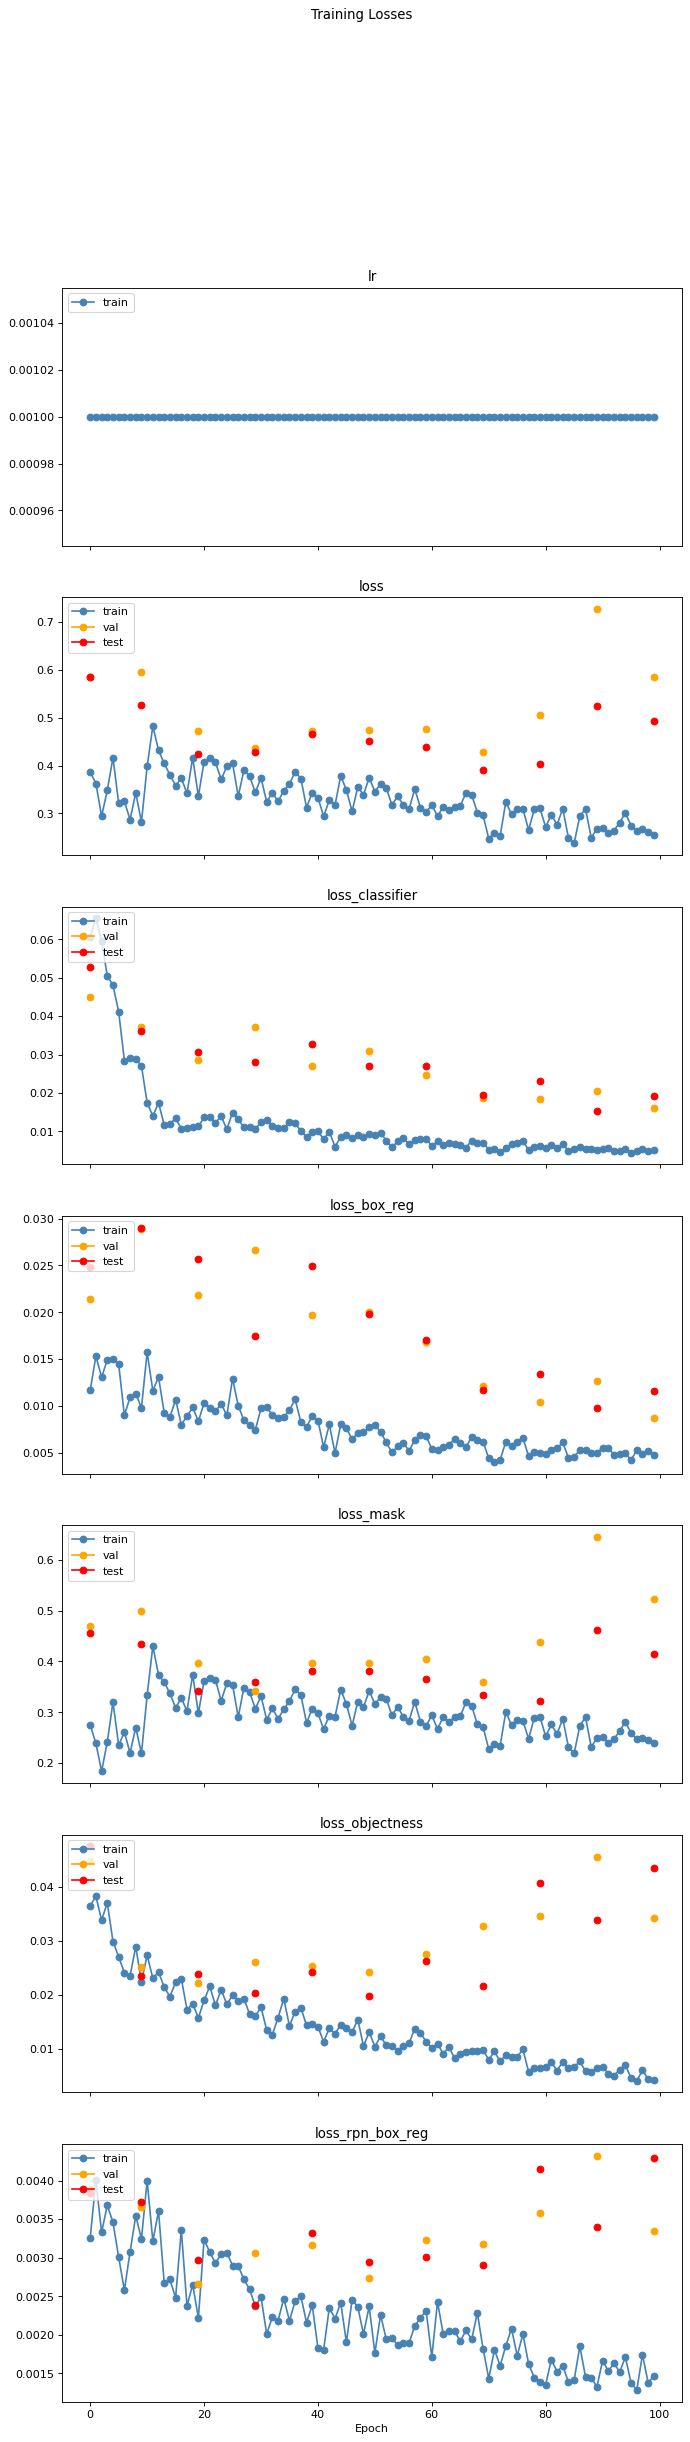

In [7]:
for train_info in train_infos:
    print(train_info)
    model_setup = train_info.model_setup
    model = create_multimodal_rcnn_model(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    print_params_setup(model)
    print(f"Max AP on test: [{max([ap_ar['ap']  for ap_ar in  train_info.test_ap_ars]):.4f}]")
    print("Labels used:\n",labels_cols)
    plot_ap_ars(
            train_ap_ars=train_info.train_ap_ars,
            val_ap_ars=train_info.val_ap_ars,
            test_ap_ars=train_info.test_ap_ars,
        )

    plot_losses(train_info.train_losses, train_info.val_losses, test_logers=train_info.test_losses)

In [8]:
# ========================================For Training [All_label_testing]========================================
# ModelSetup(name='All_label_testing', use_heatmaps=False, with_fixations=False, with_pupil=False, with_1st_third_fixations=False, with_2nd_third_fixations=False, with_rad_silence=False, with_rad_speaking=False, save_early_stop_model=True, record_training_performance=True, backbone='resnet18', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, heatmap_backbone_pretrained=True, image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, fusion_strategy='multiply', fusion_residule=False, gt_in_train_till=0, measure_test=True)
# ================================================================================================================

# Best AP validation model has been saved to: [val_ar_0_0493_ap_0_0135_test_ar_0_0500_ap_0_0114_epoch36_11-07-2022 08-00-45_All_label_testing]
# Best AR validation model has been saved to: [val_ar_0_0619_ap_0_0099_test_ar_0_0569_ap_0_0114_epoch70_11-07-2022 14-08-34_All_label_testing]
# The final model has been saved to: [val_ar_0_0487_ap_0_0112_test_ar_0_0494_ap_0_0124_epoch100_11-07-2022 19-23-44_All_label_testing]

# ================================================================================================================
# ========================================For Training [label_testing]========================================
# ModelSetup(name='label_testing', use_heatmaps=False, with_fixations=False, with_pupil=False, with_1st_third_fixations=False, with_2nd_third_fixations=False, with_rad_silence=False, with_rad_speaking=False, save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, heatmap_backbone_pretrained=True, image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, fusion_strategy='add', fusion_residule=False, gt_in_train_till=10, measure_test=True, eval_freq=10)
# ============================================================================================================

# Best AP validation model has been saved to: [val_ar_0_0035_ap_0_0040_test_ar_0_0000_ap_0_0000_epoch90_11-15-2022 16-35-48_label_testing]
# Best AR validation model has been saved to: [val_ar_0_0069_ap_0_0026_test_ar_0_0026_ap_0_0003_epoch160_11-16-2022 07-25-17_label_testing]
# The final model has been saved to: [val_ar_0_0023_ap_0_0003_test_ar_0_0053_ap_0_0020_epoch200_11-16-2022 15-21-09_label_testing]

# ============================================================================================================
# Using pretrained backbone. mobilenet_v3
# label_testing will use mask, [64] layers.
# [model]: 3,495,371
# [model.backbone]: 1,258,848
# [model.rpn]: 41,803
# [model.roi_heads]: 2,194,720
# [model.roi_heads.box_head]: 204,928
# [model.roi_heads.box_head.fc6]: 200,768
# [model.roi_heads.box_head.fc7]: 4,160
# [model.roi_heads.box_predictor]: 5,200
# [model.roi_heads.mask_head]: 1,917,952
# Max AP on test: [0.0024]


In [9]:
model.roi_heads.training

True

In [10]:
model.eval()

MultimodalMaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
    

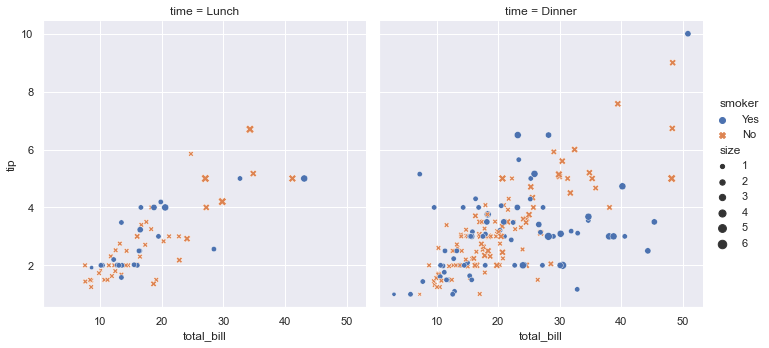

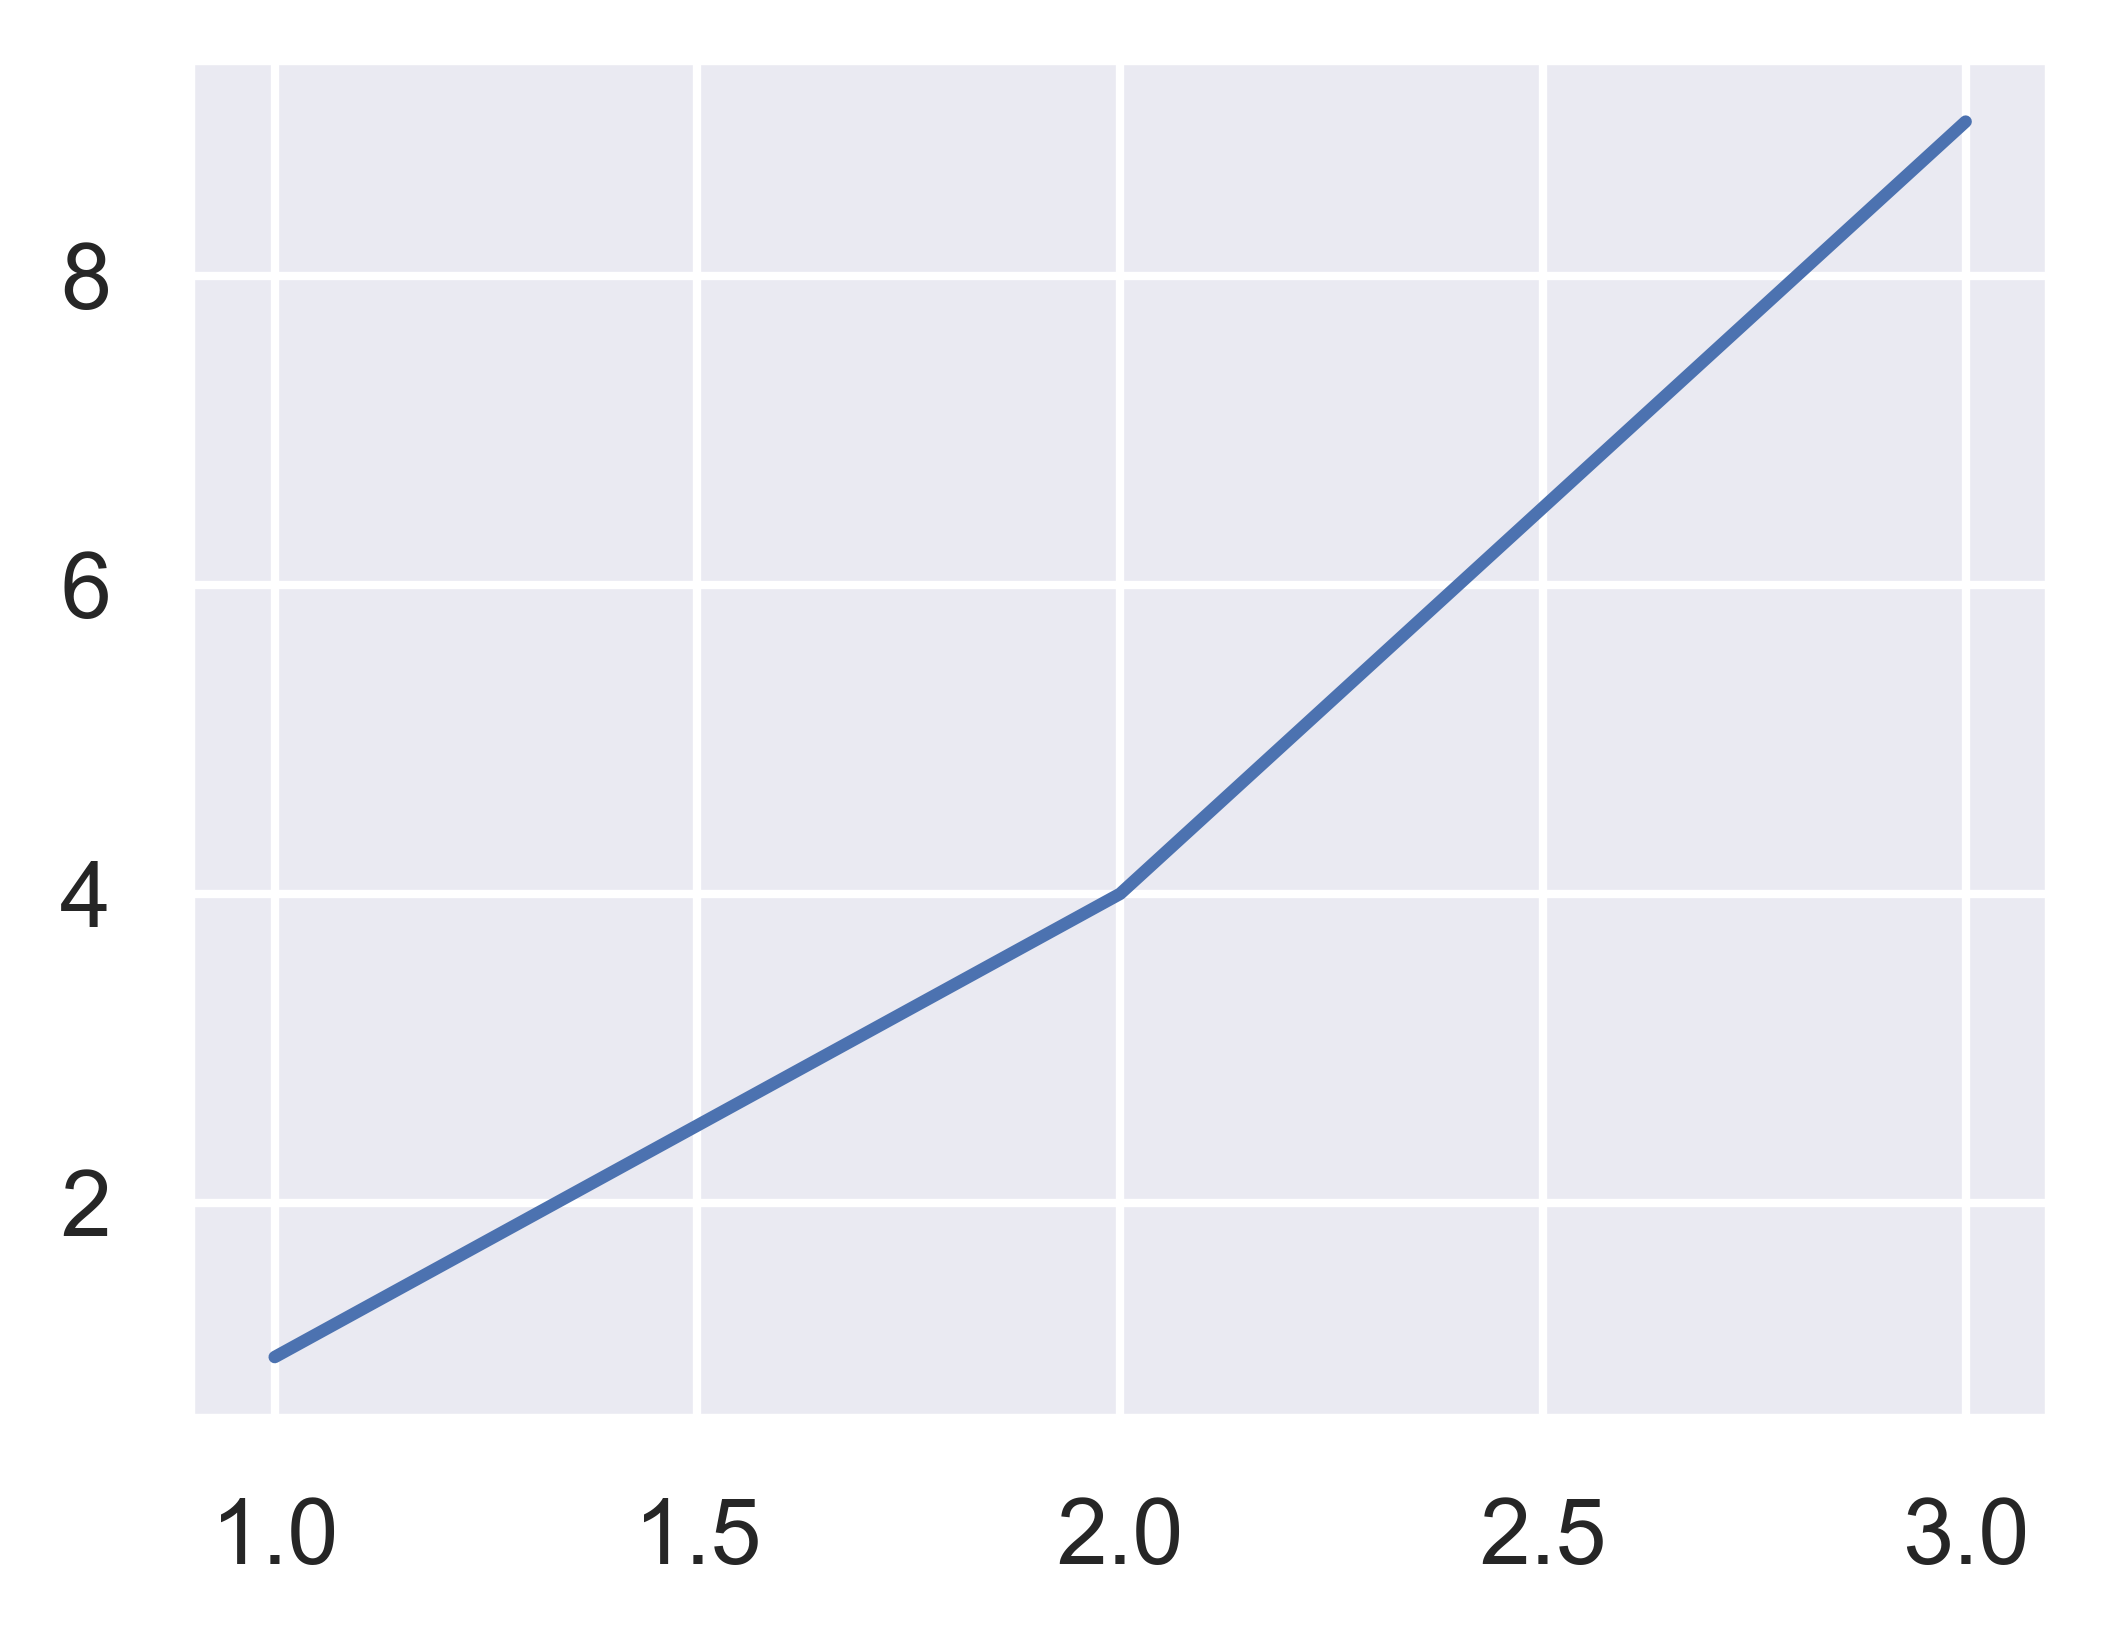

In [11]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)
# test
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 3), dpi=600)
plt.plot([1, 2, 3], [1, 4, 9])
plt.show()

In [12]:
from data.fixation import get_fixations_dict_from_fixation_df, get_heatmap

data_path = 'C:\\Users\VIMMI\Desktop\multimodal-abnormalities-detection\spreadsheets\\reflacx_for_eyetracking.csv'
fix = 'E:\XAMI-MIMIC\patient_10011607\REFLACX\P300R471381\\fixations.csv'
trans = 'E:\XAMI-MIMIC\patient_10011607\REFLACX\P300R471381\\timestamps_transcription.csv'
image = 'E:\XAMI-MIMIC\patient_10011607\CXR-JPG\s55814288\\5bdabba9-388f6646-ac06b5f5-f68b2fd2-3630de21.jpg'

data = pd.read_csv(data_path)

data = data.loc[(data['id'] == 'P300R471381') & (data['subject_id']==10011607)]

# print(data['image_size_x'])
# print(data['image_size_y'])
fix_dict = get_fixations_dict_from_fixation_df(pd.read_csv(fix))

heatmap = get_heatmap(fix_dict, (2544, 3056)).astype(np.float32)

heatmap

# get_fixations_dict_from_fixation_df(pd.read_csv(fix), pd.read_csv(trans), rad_speaking=True)




FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\VIMMI\\Desktop\\multimodal-abnormalities-detection\\spreadsheets\\reflacx_for_eyetracking.csv'

In [ ]:
from PIL import Image

img = Image.open(image).convert("RGB")

from torchvision import transforms

convert_tensor = transforms.ToTensor()
a = convert_tensor(img)
a


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
# ## we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.

# for model_setup in all_model_setups:

#     print_f.print_title("Preparing for the training.")

#     train_info = TrainingInfo(model_setup)

#     if model_setup.measure_test:
#         # initialise the test recording list.
#         train_info.test_ap_ars = []

#     model = create_multimodal_rcnn_model(
#         labels_cols,
#         model_setup,
#         rpn_nms_thresh=0.3,
#         box_detections_per_img=10,
#         box_nms_thresh=0.2,
#         rpn_score_thresh=0.0,
#         box_score_thresh=0.05,
#     )
#     model.to(device)

#     ################ Datasets ################
#     dataset_params_dict = {
#         "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
#         "with_fixations": model_setup.with_fixations,
#         "with_pupil": model_setup.with_pupil,
#         "with_1st_third_fixations": model_setup.with_1st_third_fixations,
#         "with_2nd_third_fixations": model_setup.with_2nd_third_fixations,
#         "with_rad_silence": model_setup.with_rad_silence,
#         "with_rad_speaking": model_setup.with_rad_speaking,
#         "bbox_to_mask": model_setup.use_mask,
#         "labels_cols": labels_cols,
#     }

#     print("Dataloader creating...")

#     detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
#         dataset_params_dict=dataset_params_dict,
#     )

#     train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
#         train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
#     )

#     print("Dataloader created!!")

#     # train_coco, val_coco, test_coco = get_cocos(
#     #     train_dataloader, val_dataloader, test_dataloader
#     # )

#     # eval_params_dict = get_eval_params_dict(
#     #     detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
#     # )

#     train_coco = None

#     train_coco, val_coco, test_coco, eval_params_dict = get_coco_eval_params(
#         train_dataloader, val_dataloader, test_dataloader, detect_eval_dataset
#     )

#     # dynamic_loss_weight = None
#     loss_keys = [
#         "loss_classifier",
#         "loss_box_reg",
#         "loss_objectness",
#         "loss_rpn_box_reg",
#     ]

#     dynamic_loss_weight = DynamicWeightedLoss(
#         keys=loss_keys + ["loss_mask"] if model_setup.use_mask else loss_keys
#     )
#     dynamic_loss_weight.to(device)
#     print_params_setup(model)

#     params = [p for p in model.parameters() if p.requires_grad]
#     if dynamic_loss_weight:
#         params += [p for p in dynamic_loss_weight.parameters() if p.requires_grad]

#     iou_types = get_iou_types(model, model_setup)
#     optimizer = get_optimiser(params, model_setup)
#     lr_scheduler = get_lr_scheduler(optimizer, model_setup)

#     current_time = datetime.now()

#     print_f.print_title(
#         f"Start training. Preparing Took [{ (current_time - train_info.start_t).seconds}] sec"
#     )

#     train_info.start_t = datetime.now()

#     val_loss = None

#     ## Start the training from here.
#     for e in range(num_epochs):

#         print_f.print_title(f"Training model: [{model_setup.name}]")
#         print(train_info)

#         train_info.epoch = e + 1

#         if train_info.epoch > model_setup.gt_in_train_till:
#             model.roi_heads.use_gt_in_train = False

#         ###### Perform training and show the training result here ######
#         model.train()

#         train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
#             model=model,
#             optimizer=optimizer,
#             data_loader=train_dataloader,
#             device=device,
#             epoch=train_info.epoch,
#             print_freq=10,
#             iou_types=iou_types,
#             coco=train_coco,
#             score_thres=None,
#             evaluate_on_run=True,
#             params_dict=eval_params_dict,
#             dynamic_loss_weight=dynamic_loss_weight,
#         )

#         # train_info.train_evaluators.append(train_evaluator)
#         train_info.train_losses.append(get_data_from_metric_logger(train_loger))
#         ################################################################

#         ####### Put the model into evaluation mode, start evaluating the current model #######
#         model.eval()

#         train_info.last_val_evaluator, val_logger = xami_evaluate(
#             model=model,
#             data_loader=val_dataloader,
#             device=device,
#             params_dict=eval_params_dict,
#             coco=val_coco,
#             iou_types=iou_types,
#             score_thres=None,
#         )

#         # train_info.val_evaluators.append(val_evaluator)
#         train_info.val_losses.append(get_data_from_metric_logger(val_logger))

#         train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
#             train_info.last_train_evaluator,
#             train_info.last_val_evaluator,
#             areaRng="all",
#             iouThr=0.5,
#             maxDets=10,
#         )

#         train_info.train_ap_ars.append(train_ap_ar)
#         train_info.val_ap_ars.append(val_ap_ar)

#         if model_setup.measure_test:
#             train_info.test_evaluator, test_logger = xami_evaluate(
#                 model=model,
#                 data_loader=test_dataloader,
#                 device=device,
#                 params_dict=eval_params_dict,
#                 coco=test_coco,
#                 iou_types=iou_types,
#                 score_thres=None,
#             )
#             train_info.test_losses.append(get_data_from_metric_logger(test_logger))
#             test_ap_ar = get_ap_ar(
#                 train_info.test_evaluator, areaRng="all", iouThr=0.5, maxDets=10,
#             )
#             train_info.test_ap_ars.append(test_ap_ar)

#         ### update the learning rate

#         val_loss = train_info.val_losses[-1]["loss"]

#         if train_info.epoch > model_setup.warmup_epochs:
#             if not lr_scheduler is None:
#                 if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
#                     if (
#                         model_setup.reduceLROnPlateau_full_stop
#                         and lr_scheduler.num_bad_epochs
#                         >= model_setup.reduceLROnPlateau_patience
#                     ):
#                         print_f.print_title(
#                             f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
#                         )
#                         break
#                     lr_scheduler.step(val_loss)
#                 else:
#                     lr_scheduler.step()

#         print(" if train_info.epoch > model_setup.warmup_epochs: DONE")

#         ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
#         clear_output()

#         if model_setup.record_training_performance:
#             plot_ap_ars(
#                 train_ap_ars=train_info.train_ap_ars,
#                 val_ap_ars=train_info.val_ap_ars,
#                 test_ap_ars=train_info.test_ap_ars,
#             )

#         plot_losses(
#             train_info.train_losses,
#             train_info.val_losses,
#             test_logers=train_info.test_losses,
#         )

#         previous_time = current_time
#         current_time = datetime.now()
#         epoch_took = current_time - previous_time

#         sec_took = (current_time - train_info.start_t).seconds
#         speed = sec_took / train_info.epoch

#         print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

#         if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
#             print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

#         print_f.print_title(print_str)

#         # print('below plots')

#         #######################################################################################
#         if model_setup.save_early_stop_model:
#             val_ar, val_ap, train_info = check_best(
#                 val_ap_ar=val_ap_ar,
#                 device=device,
#                 eval_params_dict=eval_params_dict,
#                 train_info=train_info,
#                 model=model,
#                 optim=optimizer,
#                 test_dataloader=test_dataloader,
#                 test_coco=test_coco,
#                 iou_types=iou_types,
#                 score_thres=None,
#                 dynamic_weight=dynamic_loss_weight,
#             )

#         # print('end of loop')

#     val_ap_ar = get_ap_ar(train_info.last_val_evaluator)

#     # print('check')

#     train_info = end_train(
#         train_info=train_info,
#         model=model,
#         optim=optimizer,
#         eval_params_dict=eval_params_dict,
#         last_val_ar=val_ap_ar["ar"],
#         last_val_ap=val_ap_ar["ap"],
#         test_dataloader=test_dataloader,
#         device=device,
#         test_coco=test_coco,
#         iou_types=iou_types,
#         score_thres=None,
#         dynamic_weight=dynamic_loss_weight,
#     )

#     train_infos.append(train_info)


# # what's the performance we can get with more or less labels?
# # what's the performance we can get with different values of gt_in_train_till.


# # let the model test on a certain frequency not all the epochs.

